In [3]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics
import trace_classification
import csv
import warnings 
warnings.filterwarnings('ignore')

# Data Preparation


Prepare the data to be used with kNN

In [4]:
plots = set()
with open('traces/traces.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        else:
            plots.add((row[1], row[2]))

plots = list(plots) 

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0:
        label = 'Gray Hole'
    elif row[1].find('bh') >= 0:
        label = 'Black Hole'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7411:11:1111:,grid_normal_2019-02-26_11:48_,58,1439.586207,705035.790684,839.664094,5,417.0,3699.0,0.710,5,Normal
1,aaaa::212:740b:b:b0b:,grid_normal_2019-02-26_11:48_,109,955.009174,549645.305471,741.380675,3,235.0,3850.0,0.455,5,Normal
2,aaaa::212:740c:c:c0c:,grid_normal_2019-02-26_11:48_,95,1102.726316,673664.626428,820.770751,3,251.0,4432.0,0.525,4,Normal
3,aaaa::212:7404:4:404:,grid_normal_2019-02-26_11:48_,76,385.115789,111308.537081,333.629341,1,65.6,1551.0,0.620,3,Normal
4,aaaa::212:740f:f:f0f:,grid_normal_2019-02-26_11:48_,88,1425.261364,955478.563088,977.485838,4,363.0,5619.0,0.560,4,Normal


Stats for single network

In [5]:
net_stats = trace_statistics.compute_labeled_statistics_by_network(stats, 'loss', 16)
net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_25_stats, 'loss', 16, 25)
net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_50_stats, 'loss', 16, 50)
net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_100_stats, 'loss', 16, 100)

# Create a dictionary containing all the statistics for each trace size
network_stats = {200: net_stats, 25: net_win_25_stats, 50: net_win_50_stats, 100: net_win_100_stats}
net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,grid_1bh-7_2019-02-19_22:13_,Black Hole,0.215,0.305,0.230,0.240,0.190,0.100,0.170,0.240,0.200,0.220,0.255,0.275,0.170,0.080,9.223372e+18,9.223372e+18
1,grid_1bh-9_2019-02-20_00:30_,Black Hole,0.040,0.210,0.070,0.160,0.010,0.025,0.045,0.015,0.130,0.075,0.250,0.125,0.205,0.100,9.223372e+18,9.223372e+18
2,grid_1gh30-7_2019-02-19_22:35_,Gray Hole,0.350,0.480,0.635,0.705,0.825,0.475,0.235,0.335,0.550,0.425,0.890,0.455,0.380,0.695,7.050000e-01,8.850000e-01
3,grid_1gh30-9_2019-02-20_00:12_,Gray Hole,0.220,0.065,0.180,0.320,0.105,0.070,0.125,0.760,0.115,0.180,0.220,0.060,0.120,0.790,1.550000e-01,1.550000e-01
4,grid_1gh50-7_2019-02-19_22:53_,Gray Hole,0.205,0.165,0.350,0.360,0.170,0.315,0.160,0.300,0.145,0.300,0.580,0.625,0.650,0.170,3.450000e-01,2.700000e-01


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

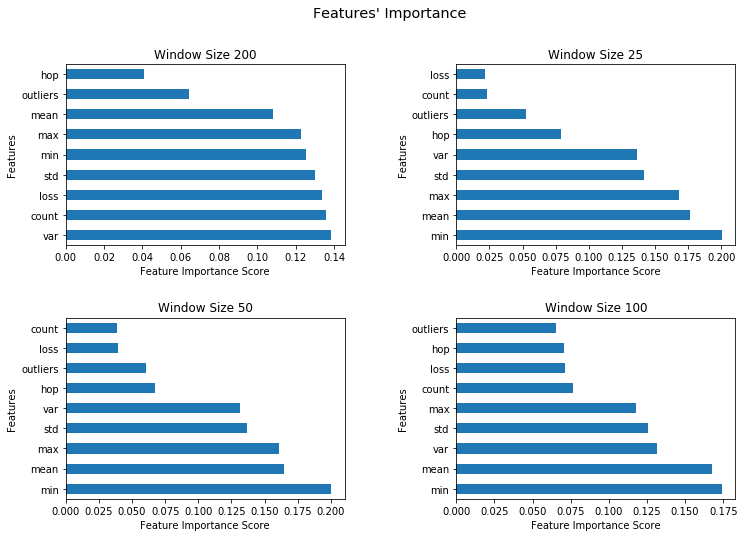

In [6]:
plots_analysis.random_forests_features_selection(trace_stats)

In [7]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm
net_results = None            # Results from each classification algorithm
cv_net_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'hop', 'loss', 'count', 'outliers']
net_features_to_drop = ['experiment', 'label']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [8]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [9]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [10]:
net_results = pd.concat([net_results, 
                     trace_classification.random_forest_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [11]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.random_forest_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

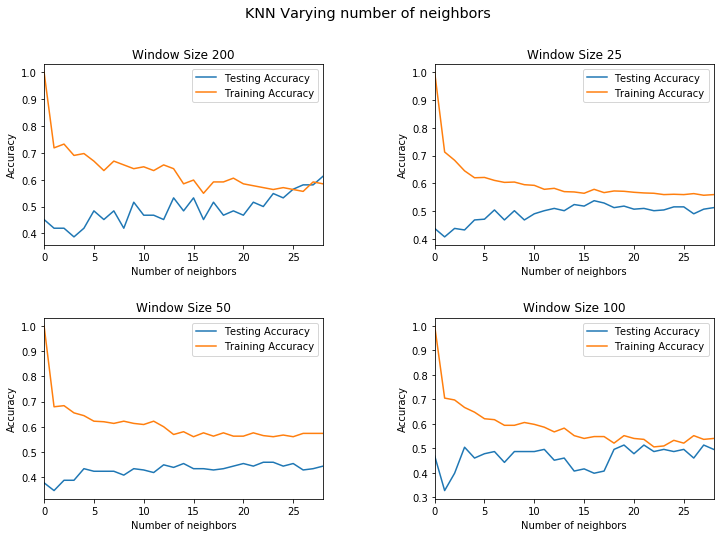

In [12]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [13]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=17)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [14]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=17)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [15]:
net_results = pd.concat([net_results, 
                     trace_classification.k_nearest_neighbor_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [16]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [17]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [18]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [19]:
net_results = pd.concat([net_results, 
                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [20]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, kernel='rbf', cross_val=3)
                    ])


Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [21]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validate

In [22]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [24]:
'''
net_results = pd.concat([net_results, 
                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)
                    ])
'''

'\nnet_results = pd.concat([net_results, \n                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)\n                    ])\n'

Cross validation

In [25]:
'''
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])
'''

'\ncv_net_results = pd.concat([cv_net_results, \n                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)\n                    ])\n'

# Per Node Results

Results for each model

In [26]:
results = results.rename(index=str, columns={"Training Time (ms)": "Training Time (sec)", "Testing Time (ms)": "Testing Time (sec)"})
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.548387,0.478395,0.478938,0.478531,0.116529,0.011201
1,Random Forest,25,0.540166,0.464306,0.447359,0.446860,0.269027,0.030150
2,Random Forest,50,0.474490,0.423907,0.421835,0.417454,0.226456,0.015211
3,Random Forest,100,0.522124,0.448219,0.434444,0.425243,0.219266,0.012538
4,KNN,200,0.451613,0.320191,0.347985,0.332589,0.002181,0.004688
5,KNN,25,0.537396,0.474962,0.440435,0.438180,0.003109,0.021872
6,KNN,50,0.433673,0.403996,0.363016,0.343869,0.002220,0.013024
7,KNN,100,0.398230,0.308539,0.307778,0.295074,0.001636,0.007585
8,SVM,200,0.403226,0.293981,0.301282,0.260401,0.003163,0.001340
9,SVM,25,0.526316,0.433296,0.419644,0.401786,0.050497,0.008031


Here we plot the average results for each model

In [27]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.471312
1,Random Forest,25,0.462998
2,Random Forest,50,0.474880
3,Random Forest,100,0.463016
4,KNN,200,0.378258
5,KNN,25,0.478891
6,KNN,50,0.430605
7,KNN,100,0.428104
8,SVM,200,0.388142
9,SVM,25,0.488756


# Network Results
Here we print the results from each model on the whole network

In [28]:
net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.25000,0.111111,0.333333,0.166667,0.113062,0.026724
1,Random Forest,25,0.46875,0.330113,0.342262,0.313514,0.116735,0.010530
2,Random Forest,50,0.12500,0.084656,0.097222,0.088889,0.119547,0.013149
3,Random Forest,100,0.37500,0.428571,0.400000,0.259259,0.114518,0.011270
4,KNN,200,0.25000,0.125000,0.500000,0.200000,0.001493,0.002028
5,KNN,25,0.31250,0.151515,0.208333,0.175439,0.001448,0.003015
6,KNN,50,0.06250,0.033333,0.055556,0.041667,0.001468,0.003373
7,KNN,100,0.37500,0.500000,0.400000,0.428571,0.001657,0.002007
8,SVM,200,0.25000,0.125000,0.500000,0.200000,0.001330,0.001397
9,SVM,25,0.50000,0.166667,0.333333,0.222222,0.002221,0.001508


Here we plot the average results for each model computed with cross validation

In [29]:
cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.311111
1,Random Forest,25,0.290305
2,Random Forest,50,0.210648
3,Random Forest,100,0.350000
4,KNN,200,0.444444
5,KNN,25,0.259804
6,KNN,50,0.192130
7,KNN,100,0.416667
8,SVM,200,0.511111
9,SVM,25,0.319172
